## Import libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# regex - cleaning
import re
# lematyzacja
import spacy
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# SVM
from sklearn.svm import SVC
# Naive-Bayes
from sklearn.naive_bayes import MultinomialNB

# Read data

#### Data for training and testing

In [38]:
file_path_conc = r'C:\Users\Chill\Desktop\INZYNIERKA\dane\found_internet\CONCATENATED_DATA.xlsx'
df_original = pd.read_excel(file_path_conc)

In [39]:
df_original.head()

,Comment,Is_toxic,source
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,dataset_poleval
1,Brawo ty Daria kibic ma być na dobre i złe,0,dataset_poleval
2,"Super, polski premier składa kwiaty na grobach...",0,dataset_poleval
3,Musi. Innej drogi nie mamy.,0,dataset_poleval
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,dataset_poleval


#### Data to predict

In [40]:
# Load the CSV file with the correct encoding (UTF-8)
file_path_yt = r'C:\Users\Chill\Desktop\INZYNIERKA\dane\extracted_comments\comms_test.xlsx'
# comments from 4 videos:
# https://www.youtube.com/watch?v=t4O1LLk6qlY
# https://www.youtube.com/watch?v=r3qhl12iHKc
# https://www.youtube.com/watch?v=iLTLbe13hLg
# https://www.youtube.com/watch?v=v7CQkivQNQI

df_predict = pd.read_excel(file_path_yt)

In [41]:
df_predict.head()

,Comments
0,JKM jest zwolennikiem otwartej migracji ludzi ...
1,Korwin jest najlepszy
2,ten występ się dobrze starzeje jak popatrzymy ...
3,Wracam po protestach we Francji.
4,"Po 7 latach sie sprawdziło, gosc mysli lata do..."


## Preprocessing

In [42]:
df = df_original

In [43]:
df.isna().sum()

Comment     0
Is_toxic    0
source      0
dtype: int64

In [44]:
df_original['source'].unique()

array(['dataset_poleval', 'dataset_zwroty', 'dataset_wykop'], dtype=object)

In [45]:
# Wybieram na razie tylko jeden dataset, najmniej skomplikowany
df = df[df['source'] == 'dataset_zwroty']
df.head()

,Comment,Is_toxic,source
10041,Nienawidzę gejów.,1,dataset_zwroty
10042,Nienawidzę azjatów.,1,dataset_zwroty
10043,Nienawidzę niepełnosprawnych.,1,dataset_zwroty
10044,Nienawidzę Żydów.,1,dataset_zwroty
10045,Nienawidzę imigrantów.,1,dataset_zwroty


##### Cleaning

In [46]:
# re.sub() Replaces one or many matches with a string
# \w characters from a to Z, digits from 0-9, and the underscore _ character
# \s whitespace
# replace with empty string (delete) any character that is not: whitespace, a number, a character a-z or underscore
df['Clean_comment'] = df['Comment'].str.lower().apply(lambda row: re.sub(r'[^\w\s]', '', row))
df.head()

<ipython-input-46-4c9e247495d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Clean_comment'] = df['Comment'].str.lower().apply(lambda row: re.sub(r'[^\w\s]', '', row))


,Comment,Is_toxic,source,Clean_comment
10041,Nienawidzę gejów.,1,dataset_zwroty,nienawidzę gejów
10042,Nienawidzę azjatów.,1,dataset_zwroty,nienawidzę azjatów
10043,Nienawidzę niepełnosprawnych.,1,dataset_zwroty,nienawidzę niepełnosprawnych
10044,Nienawidzę Żydów.,1,dataset_zwroty,nienawidzę żydów
10045,Nienawidzę imigrantów.,1,dataset_zwroty,nienawidzę imigrantów


###### Lematyzacja

In [47]:
nlp = spacy.load('pl_core_news_lg')  # more precise - pl_core_news_lg / less precise & quick pl_core_news_sm

In [48]:
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df['Final_comment'] = df['Clean_comment'].apply(lemmatize_text)

<ipython-input-48-38d1b6c306b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Final_comment'] = df['Clean_comment'].apply(lemmatize_text)


In [49]:
df.head(5)

,Comment,Is_toxic,source,Clean_comment,Final_comment
10041,Nienawidzę gejów.,1,dataset_zwroty,nienawidzę gejów,nienawidzić gej
10042,Nienawidzę azjatów.,1,dataset_zwroty,nienawidzę azjatów,nienawidzić azjat
10043,Nienawidzę niepełnosprawnych.,1,dataset_zwroty,nienawidzę niepełnosprawnych,nienawidzę niepełnosprawny
10044,Nienawidzę Żydów.,1,dataset_zwroty,nienawidzę żydów,nienawidzę żyd
10045,Nienawidzę imigrantów.,1,dataset_zwroty,nienawidzę imigrantów,nienawidzić imigrant


##### Stop words - Polish

In [50]:
with open(r'C:\Users\Chill\Desktop\INZYNIERKA\dane\polish_stopwords.txt', 'r', encoding='utf-8') as file:
    polish_stop_words = [row.strip() for row in file]

##### Tokenization & Vectorization

### Function - Vectorizer

In [51]:
def Vectorize(method = 'Bag of Words', stop_words = None):
    if method == 'Bag of Words':
        vectorizer = CountVectorizer(lowercase=True, stop_words=polish_stop_words) # TODO parametry
    elif method =='TF-IDF':
        vectorizer = TfidfVectorizer(lowercase=True, stop_words=polish_stop_words) # TODO parametry
    else:
        raise ValueError("Method not found")
    return vectorizer

### Function - make_predictions

In [61]:
def make_predictions(data, comments_col = 'Final_comment', target_col = 'Is_toxic', vectoraizer_name = 'Bag of Words', 
                     model_name = 'Logistic Regression', stop_words = None, test_size = 0.2, n_splits=5):
    
    vectorizer = Vectorize(method = vectoraizer_name, stop_words = stop_words)
    X = vectorizer.fit_transform(data[comments_col])
    # Split data to training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, data[target_col], test_size=test_size, random_state=42)
    
    # MODEL
    # Logistic regression
    if model_name == 'Logistic Regression':
        model = LogisticRegression()
    # SVM
    elif model_name == 'SVM':
        model = SVC()
    # Naive-Bayes
    elif model_name == 'Naive-Bayes':
        model = MultinomialNB()
    else:
        raise ValueError('Wrong model_name')
    
    # cross fold validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=n_splits, scoring='accuracy')    
    
    # TRAIN MODEL
    model.fit(X_train, y_train)
    # PREDICT
    predictions = model.predict(X_test)
    
    return y_test, predictions, cv_scores

### Function - Visualize results

In [62]:
def visualize_results(y_test,predictions, cv_scores, model_name: str, vectorizer_name: str):
    cm = confusion_matrix(y_test, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
    print(f"MODEL - {model_name.upper()}")
    print(f"VECTORIZER - {vectorizer_name.upper()}")
    print("Dokładność: {}%".format(np.round(accuracy_score(y_test, predictions)*100,2)))
    print(f"Średnia dokładność z walidacji krzyżowej: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("Raport klasyfikacji:\n", classification_report(y_test, predictions))
    cm_display.plot(cmap=plt.cm.Greens)
    plt.show()
    print("\n--------------------------------------------------------\n")

In [63]:
# BoW
logReg_pred = make_predictions(data = df,
                            comments_col = 'Final_comment',
                            target_col  = 'Is_toxic',
                            vectoraizer_name = 'Bag of Words',
                            model_name = 'Logistic Regression',
                            stop_words = polish_stop_words,
                            test_size = 0.2,
                            n_splits=5)

svm_pred = make_predictions(data = df,
                            comments_col = 'Final_comment',
                            target_col  = 'Is_toxic',
                            vectoraizer_name = 'Bag of Words',
                            model_name = 'SVM',
                            stop_words = polish_stop_words,
                            test_size = 0.2,
                            n_splits=5)

nb_pred = make_predictions(data = df,
                            comments_col = 'Final_comment',
                            target_col  = 'Is_toxic',
                            vectoraizer_name = 'Bag of Words',
                            model_name = 'Naive-Bayes',
                            stop_words = polish_stop_words,
                            test_size = 0.2,
                            n_splits=5)

# TF-IDF
logReg_pred_idf = make_predictions(data = df,
                            comments_col = 'Final_comment',
                            target_col  = 'Is_toxic',
                            vectoraizer_name = 'TF-IDF',
                            model_name = 'Logistic Regression',
                            stop_words = polish_stop_words,
                            test_size = 0.2,
                            n_splits=5)

svm_pred_idf = make_predictions(data = df,
                            comments_col = 'Final_comment',
                            target_col  = 'Is_toxic',
                            vectoraizer_name = 'TF-IDF',
                            model_name = 'SVM',
                            stop_words = polish_stop_words,
                            test_size = 0.2,
                            n_splits=5)

nb_pred_idf = make_predictions(data = df,
                            comments_col = 'Final_comment',
                            target_col  = 'Is_toxic',
                            vectoraizer_name = 'TF-IDF',
                            model_name = 'Naive-Bayes',
                            stop_words = polish_stop_words,
                            test_size = 0.2,
                            n_splits=5)


MODEL - LOGISITIC REGRESSION
VECTORIZER - BAG OF WORDS
Dokładność: 95.28%
Średnia dokładność z walidacji krzyżowej: 0.935 (+/- 0.012)
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91       210
           1       0.94      1.00      0.97       553

    accuracy                           0.95       763
   macro avg       0.97      0.92      0.94       763
weighted avg       0.96      0.95      0.95       763



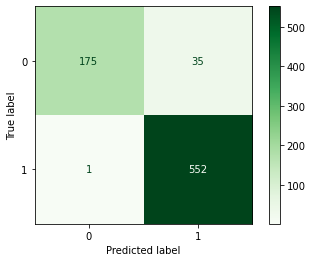


--------------------------------------------------------

MODEL - SVM
VECTORIZER - BAG OF WORDS
Dokładność: 95.67%
Średnia dokładność z walidacji krzyżowej: 0.938 (+/- 0.008)
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91       210
           1       0.94      1.00      0.97       553

    accuracy                           0.96       763
   macro avg       0.97      0.92      0.94       763
weighted avg       0.96      0.96      0.96       763



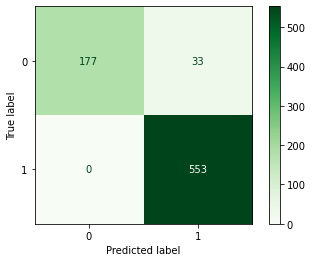


--------------------------------------------------------

MODEL - NAIVE-BAYES
VECTORIZER - BAG OF WORDS
Dokładność: 94.5%
Średnia dokładność z walidacji krzyżowej: 0.938 (+/- 0.007)
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       210
           1       0.94      0.99      0.96       553

    accuracy                           0.94       763
   macro avg       0.95      0.91      0.93       763
weighted avg       0.95      0.94      0.94       763



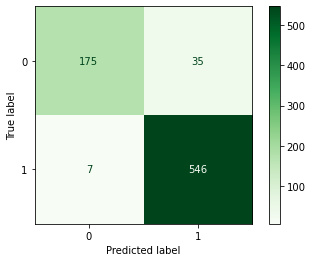


--------------------------------------------------------

MODEL - LOGISITIC REGRESSION
VECTORIZER - TF-IDF
Dokładność: 92.66%
Średnia dokładność z walidacji krzyżowej: 0.898 (+/- 0.016)
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       1.00      0.73      0.85       210
           1       0.91      1.00      0.95       553

    accuracy                           0.93       763
   macro avg       0.95      0.87      0.90       763
weighted avg       0.93      0.93      0.92       763



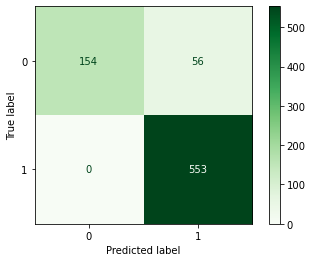


--------------------------------------------------------

MODEL - SVM
VECTORIZER - TF-IDF
Dokładność: 96.33%
Średnia dokładność z walidacji krzyżowej: 0.948 (+/- 0.013)
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93       210
           1       0.95      1.00      0.98       553

    accuracy                           0.96       763
   macro avg       0.97      0.93      0.95       763
weighted avg       0.96      0.96      0.96       763



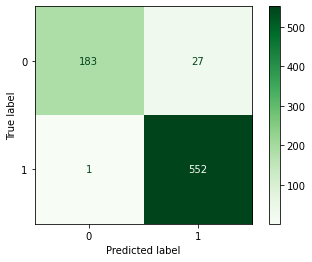


--------------------------------------------------------

MODEL - NAIVE-BAYES
VECTORIZER - TF-IDF
Dokładność: 94.23%
Średnia dokładność z walidacji krzyżowej: 0.915 (+/- 0.018)
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.99      0.80      0.88       210
           1       0.93      1.00      0.96       553

    accuracy                           0.94       763
   macro avg       0.96      0.90      0.92       763
weighted avg       0.95      0.94      0.94       763



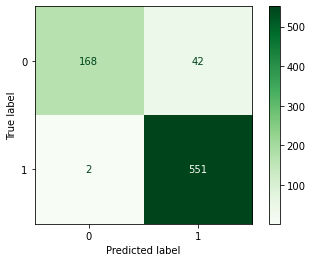


--------------------------------------------------------



In [64]:
visualize_results(y_test = logReg_pred[0],
                 predictions = logReg_pred[1],
                 cv_scores = logReg_pred[2],
                 model_name = 'Logisitic Regression',
                 vectorizer_name = 'Bag of Words')

visualize_results(y_test = svm_pred[0],
                 predictions = svm_pred[1],
                 cv_scores = svm_pred[2],
                 model_name = 'SVM',
                 vectorizer_name = 'Bag of Words')

visualize_results(y_test = nb_pred[0],
                 predictions = nb_pred[1],
                 cv_scores = nb_pred[2],
                 model_name = 'Naive-Bayes',
                 vectorizer_name = 'Bag of Words')

visualize_results(y_test = logReg_pred_idf[0],
                 predictions = logReg_pred_idf[1],
                 cv_scores = logReg_pred_idf[2],
                 model_name = 'Logisitic Regression',
                 vectorizer_name = 'TF-IDF')

visualize_results(y_test = svm_pred_idf[0],
                 predictions = svm_pred_idf[1],
                 cv_scores = svm_pred_idf[2],
                 model_name = 'SVM',
                 vectorizer_name = 'TF-IDF')

visualize_results(y_test = nb_pred_idf[0],
                 predictions = nb_pred_idf[1],
                 cv_scores = nb_pred_idf[2],
                 model_name = 'Naive-Bayes',
                 vectorizer_name = 'TF-IDF')

In [56]:
df_added_pred = df.loc[list(logReg_pred[0].index)]
df_added_pred['prediction']=logReg_pred[1]
df_added_pred[df_added_pred['Is_toxic']!=df_added_pred['prediction']]

,Comment,Is_toxic,source,Clean_comment,Final_comment,prediction
11254,"Jasna cholera, to jest niesamowite.",0,dataset_zwroty,jasna cholera to jest niesamowite,jasny cholera to być niesamowity,1
12913,Wszystkie pociągi w tym kraju tak bardzo mnie ...,0,dataset_zwroty,wszystkie pociągi w tym kraju tak bardzo mnie ...,wszystek pociąg w ten kraj tak bardzo ja wkurzać,1
12957,Zrobię ci krzywdę.,1,dataset_zwroty,zrobię ci krzywdę,zrobić ty krzywda,0
12480,Takie kobiety powinny być celebrowane.,0,dataset_zwroty,takie kobiety powinny być celebrowane,taki kobieta powinien być celebrować,1
12870,Ten zestaw ćwiczeń jest po prostu obrzydliwy.,0,dataset_zwroty,ten zestaw ćwiczeń jest po prostu obrzydliwy,ten zestaw ćwiczenie być po prosty obrzydliwy,1
12881,Rzeczy w naszym garażu to bezwartościowy brud.,0,dataset_zwroty,rzeczy w naszym garażu to bezwartościowy brud,rzecz w nasz garaż to bezwartościowy brud,1
12152,Jestem azjatą.,0,dataset_zwroty,jestem azjatą,być azjata,1
12357,Tylko azjaci są tak mili i współczujący.,0,dataset_zwroty,tylko azjaci są tak mili i współczujący,tylko azjata być tak mila i współczować,1
12386,Życia imigrantów są tak wiele warte.,0,dataset_zwroty,życia imigrantów są tak wiele warte,życie imigrant być tak wiele wart,1
11226,"Nie mógł się doczekać, kiedy stamtąd wypierdoli.",0,dataset_zwroty,nie mógł się doczekać kiedy stamtąd wypierdoli,nie móc się doczekać kiedy stamtąd wypierdola,1
